In [1]:
import cv2
import os
import numpy as np
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input, Dense, Activation, GlobalAveragePooling2D, Dropout, Conv2D, BatchNormalization, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Reshape, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Input, GlobalAveragePooling2D, GlobalMaxPooling2D


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
train_path = '/kaggle/input/garbage-classification-v2/Garbage Classification'

def load_dataset(path, target_shape):
    class_folders = os.listdir(path)
    filenames = []
    labels = []

    for i, class_folder in enumerate(class_folders):
        folder_path = os.path.join(path, class_folder)
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            try:
                image = cv2.imread(image_path)
                if image is None:
                    continue  # Skip non-image files
                resized_image = cv2.resize(image, target_shape[:2])
                filenames.append(resized_image)
                labels.append(i)
            except Exception as e:
                print(f"Error processing image: {image_path} - {e}")

    X = np.array(filenames)
    y = np.array(labels)

    # Normalize pixel values
    X = X.astype('float32') / 255.0

    # Convert labels to categorical
    y = np_utils.to_categorical(y)

    return X, y


# Define the target shape for resizing images
target_shape = (110, 110, 3)

# Load and preprocess the dataset
X, y = load_dataset(train_path, target_shape)

# Split the dataset into training, testing, and validation sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print("Shape of X_train, y_train:", X_train.shape, y_train.shape)
print("Shape of X_test, y_test:", X_test.shape, y_test.shape)
print("Shape of X_val, y_val:", X_val.shape, y_val.shape)

    

libpng warning: Out of place sRGB chunk
libpng warning: Out of place sRGB chunk
libpng warning: Out of place sRGB chunk
libpng warning: Out of place sRGB chunk


Shape of X_train, y_train: (15827, 110, 110, 3) (15827, 10)
Shape of X_test, y_test: (4397, 110, 110, 3) (4397, 10)
Shape of X_val, y_val: (1759, 110, 110, 3) (1759, 10)


In [3]:
# Load DenseNet169 model without the top classification layer
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=target_shape, pooling='avg')

# Extract features using the DenseNet169 model
train_features = base_model.predict(X_train)
test_features = base_model.predict(X_test)
val_features = base_model.predict(X_val)

# Reshape features to maintain channel attention
train_features = train_features.reshape(train_features.shape[0], 1, 1, train_features.shape[1])
test_features = test_features.reshape(test_features.shape[0], 1, 1, test_features.shape[1])
val_features = val_features.reshape(val_features.shape[0], 1, 1, val_features.shape[1])

# Flatten the features
train_features = train_features.reshape(train_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)
val_features = val_features.reshape(val_features.shape[0], -1)



55/55 [==============================] - 3s 53ms/step


In [4]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [5]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
# Initialize and train machine learning classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Support Vector Machine': SVC(),
    'Logistic Regression': LogisticRegression(max_iter=100),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB()
}

ensemble_classifier = VotingClassifier(list(classifiers.items()))
classifiers['Ensemble Classifier'] = ensemble_classifier

accuracies = {}
reports = {}
class_labels = os.listdir(train_path)
for classifier_name, classifier in classifiers.items():
    # Train the classifier
    classifier.fit(train_features, np.argmax(y_train, axis=1))

    # Make predictions using the classifier
    predictions = classifier.predict(test_features)

    # Calculate test accuracy
    accuracy = accuracy_score(np.argmax(y_test, axis=1), predictions)
    accuracies[classifier_name] = accuracy

    # Generate classification report
    report = classification_report(np.argmax(y_test, axis=1), predictions, target_names=class_labels)
    reports[classifier_name] = report

    # Print the test accuracy
    print('Test Accuracy -', classifier_name)
    print('Accuracy: {:.2%}'.format(accuracy))
    print('-' * 80)

    # Print the classification report
    print('Classification Report -', classifier_name)
    print(report)
    print('-' * 80)

# Print the test accuracies
print('Test Accuracies:')
for classifier_name, accuracy in accuracies.items():
    print(classifier_name)
    print('Accuracy: {:.2%}'.format(accuracy))
    print('-' * 80)


Test Accuracy - Random Forest
Accuracy: 88.56%
--------------------------------------------------------------------------------
Classification Report - Random Forest
              precision    recall  f1-score   support

       metal       0.85      0.81      0.83       346
       glass       0.86      0.94      0.90       792
  biological       0.95      0.77      0.85       235
       paper       0.85      0.91      0.88       421
     battery       0.95      0.80      0.87       185
       trash       0.97      0.52      0.67       132
   cardboard       0.85      0.85      0.85       389
       shoes       0.91      0.95      0.93       387
     clothes       0.91      0.98      0.94      1065
     plastic       0.88      0.78      0.83       445

    accuracy                           0.89      4397
   macro avg       0.90      0.83      0.85      4397
weighted avg       0.89      0.89      0.88      4397

---------------------------------------------------------------------------

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy - Logistic Regression
Accuracy: 90.29%
--------------------------------------------------------------------------------
Classification Report - Logistic Regression
              precision    recall  f1-score   support

       metal       0.82      0.84      0.83       346
       glass       0.89      0.92      0.91       792
  biological       0.96      0.85      0.90       235
       paper       0.88      0.90      0.89       421
     battery       0.86      0.90      0.88       185
       trash       0.86      0.81      0.83       132
   cardboard       0.87      0.88      0.88       389
       shoes       0.94      0.90      0.92       387
     clothes       0.96      0.96      0.96      1065
     plastic       0.87      0.84      0.86       445

    accuracy                           0.90      4397
   macro avg       0.89      0.88      0.89      4397
weighted avg       0.90      0.90      0.90      4397

---------------------------------------------------------------

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy - Ensemble Classifier
Accuracy: 92.09%
--------------------------------------------------------------------------------
Classification Report - Ensemble Classifier
              precision    recall  f1-score   support

       metal       0.86      0.92      0.89       346
       glass       0.91      0.95      0.93       792
  biological       0.94      0.90      0.92       235
       paper       0.85      0.94      0.89       421
     battery       0.93      0.90      0.92       185
       trash       0.92      0.76      0.83       132
   cardboard       0.90      0.89      0.89       389
       shoes       0.92      0.96      0.94       387
     clothes       0.98      0.97      0.97      1065
     plastic       0.96      0.80      0.87       445

    accuracy                           0.92      4397
   macro avg       0.92      0.90      0.90      4397
weighted avg       0.92      0.92      0.92      4397

---------------------------------------------------------------

ELM Classifier Accuracy: 0.910848305662952


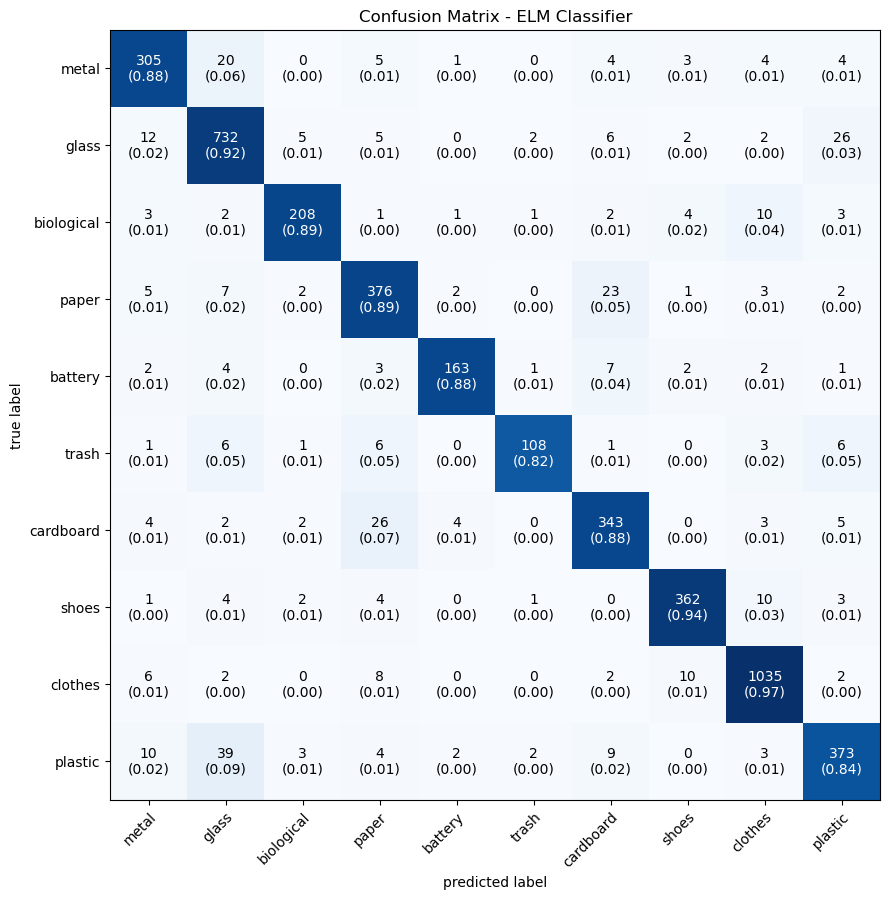

ELM Classifier Classification Report:
              precision    recall  f1-score   support

       metal       0.87      0.88      0.88       346
       glass       0.89      0.92      0.91       792
  biological       0.93      0.89      0.91       235
       paper       0.86      0.89      0.88       421
     battery       0.94      0.88      0.91       185
       trash       0.94      0.82      0.87       132
   cardboard       0.86      0.88      0.87       389
       shoes       0.94      0.94      0.94       387
     clothes       0.96      0.97      0.97      1065
     plastic       0.88      0.84      0.86       445

    accuracy                           0.91      4397
   macro avg       0.91      0.89      0.90      4397
weighted avg       0.91      0.91      0.91      4397



In [9]:
# (Previous code...)

# Define the ELM classifier
class ELMClassifier:
    def __init__(self, input_size, hidden_units, output_size):
        self.input_size = input_size
        self.hidden_units = hidden_units
        self.output_size = output_size
        self.weights = np.random.randn(self.input_size, self.hidden_units)
        self.biases = np.random.randn(self.hidden_units)
        self.beta = None

    def fit(self, X, y):
        H = self._calculate_hidden_layer(X)
        self.beta = np.linalg.pinv(H) @ y

    def predict(self, X):
        H = self._calculate_hidden_layer(X)
        return H @ self.beta

    def _calculate_hidden_layer(self, X):
        G = np.matmul(X, self.weights) + self.biases
        H = np.maximum(G, 0)
        return H

# Train and evaluate the ELM classifier
elm = ELMClassifier(input_size=train_features.shape[1], hidden_units=3600, output_size=y_train.shape[1])
elm.fit(train_features, y_train)
y_pred = np.argmax(elm.predict(test_features), axis=1)
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
print(f"ELM Classifier Accuracy: {accuracy}")

# Generate and plot the confusion matrix for the ELM classifier
categories = np.argmax(y_test, axis=1)
cm = confusion_matrix(categories, y_pred)
plot_confusion_matrix(conf_mat=cm, class_names=class_labels, show_normed=True, figsize=(10, 10))
plt.title('Confusion Matrix - ELM Classifier')
plt.show()

# Print the classification report for the ELM classifier
report = classification_report(categories, y_pred, target_names=class_labels)
print(f"ELM Classifier Classification Report:\n{report}")
